In [1]:
print("Importing...")
from pprint import pprint
import json
import sys
import os
from shutil import rmtree
from copy import deepcopy
from os.path import join
from os.path import isfile
from importlib import reload

from os.path import isdir
from os.path import join
from os import mkdir
from shutil import rmtree

import numpy as np
import pandas as pd
from scipy import stats
from matplotlib import pyplot as plt
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import f1_score

from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow import keras
from keras import callbacks
from keras import losses
from keras import metrics
from keras import optimizers
from keras import layers
from keras import regularizers
import tensorflow_addons as tfa

sys.path.insert(0, os.path.join(os.getcwd(), "../scs"))
import scs_config as scsc
import data_loading as dl
import data_degrading as dd
import data_preparation as dp
import data_augmentation as da
import data_plotting as dplt
import learn
import lr_schedules
import hp_sets

from data_loading import load_sn_data
from prepare_R_data import prepare_R_data
from prepare_datasets_for_training import extract
from prepare_datasets_for_training import add_dim
from learn import get_model, compile_model, get_lr_schedule, get_callbacks, train, evaluate

Importing...


In [2]:
hp = {
    "phase_range": (-20, 50),
    "ptp_range": (0.1, 100),
    "wvl_range": (4500, 7000),
    "train_frac": 0.65,
    "noise_scale": 0.1,
    "spike_scale": 1.0,
    "max_spikes": 3,
    "random_state": None,
    
    "model_type": "feed_forward",
    "add_dim": False,
    "swap": False,
    "units": [1024, 1024, 1024],
    "activation": "relu",
    "dropout": 0.1,
    
    # "model_type": "transformer_encoder",
    # "add_dim": True,
    # "swap": True,
    # "encoder_blocks": 1,
    # "encoder_heads": 8,
    # "encoder_key_dim": 32,
    # "encoder_proj_dim": 2048,
    # "encoder_dropout_attention": 0.1,
    # "encoder_dropout_projection": 0.1,
    # "feed_forward_units": [1024, 1024, 1024],
    # "feed_forward_activation": "relu",
    # "feed_forward_dropout": 0.1,

    "lr_schedule": "constant_lr",
    "lr0": 1e-5,
    "epochs": 10_000,
    "batch_size": 32,
}


In [3]:
R = 100
data_dir_original = "/home/2649/repos/SCS/data/"
dir_models = "/lustre/lrspec/users/2649/models/hierarchical_testing"

In [4]:
# Construct the directories if they don't exist or delete them and recreate
# them if they do and `restart_fit` is `True`.
dir_model = join(dir_models, f"{R}_dev")
dir_backup = join(dir_model, "backup")
dir_model_data = join(dir_model, "data")
if isdir(dir_model):
    rmtree(dir_model)
mkdir(dir_model)
mkdir(dir_backup)
mkdir(dir_model_data)

In [52]:
file_trn = join(dir_model_data, f"sn_data_trn.RPA.parquet")
file_tst = join(dir_model_data, f"sn_data_tst.RP.parquet")

if not (isfile(file_trn) and isfile(file_tst)):
    # Prepare the dataset from the original dataset dataframe `sn_data_file`.
    sn_data_file = join(data_dir_original, "sn_data.parquet")
    df_RPA_trn, df_RP_tst = prepare_R_data(
        R,
        sn_data_file,
        phase_range=hp["phase_range"],
        ptp_range=hp["ptp_range"],
        wvl_range=hp["wvl_range"],
        train_frac=hp["train_frac"],
        noise_scale=hp["noise_scale"],
        spike_scale=hp["spike_scale"],
        max_spikes=hp["max_spikes"],
        random_state=hp["random_state"],
    )
    df_RPA_trn.to_parquet(file_trn)
    df_RP_tst.to_parquet(file_tst)

# Load the dataset.
df_trn = load_sn_data(file_trn)
df_tst = load_sn_data(file_tst)

# Maintype Classification

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 139)]             0         
                                                                 
 dense (Dense)               (None, 1024)              143360    
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 1024)              1049600   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 1024)              1049600   
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0     

2023-07-05 17:43:21.940982: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/shared/slurm/lib:/lustre/lrspec/users/2649/anaconda3/envs/fox/lib/:/lustre/lrspec/users/2649/anaconda3/envs/fox/lib/
2023-07-05 17:43:21.941032: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-07-05 17:43:21.941072: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (r2x00): /proc/driver/nvidia/version does not exist
2023-07-05 17:43:21.941321: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appro


Epoch 1: val_loss improved from inf to 0.21945, saving model to /lustre/lrspec/users/2649/models/hierarchical_testing/100_dev/model.hdf5
716/716 - 10s - loss: 0.5259 - ca: 0.8423 - f1: 0.8319 - val_loss: 0.2195 - val_ca: 0.9285 - val_f1: 0.8627 - lr: 1.0000e-05 - 10s/epoch - 13ms/step
Epoch 2/10000

Epoch 2: val_loss improved from 0.21945 to 0.16255, saving model to /lustre/lrspec/users/2649/models/hierarchical_testing/100_dev/model.hdf5
716/716 - 8s - loss: 0.1653 - ca: 0.9545 - f1: 0.9509 - val_loss: 0.1626 - val_ca: 0.9437 - val_f1: 0.8771 - lr: 1.0000e-05 - 8s/epoch - 12ms/step
Epoch 3/10000

Epoch 3: val_loss improved from 0.16255 to 0.14352, saving model to /lustre/lrspec/users/2649/models/hierarchical_testing/100_dev/model.hdf5
716/716 - 8s - loss: 0.1050 - ca: 0.9679 - f1: 0.9652 - val_loss: 0.1435 - val_ca: 0.9458 - val_f1: 0.8795 - lr: 1.0000e-05 - 8s/epoch - 12ms/step
Epoch 4/10000

Epoch 4: val_loss improved from 0.14352 to 0.13009, saving model to /lustre/lrspec/users/264

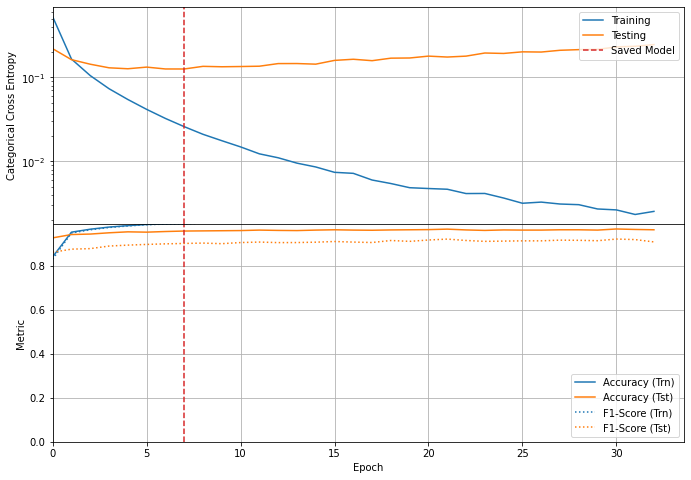

In [6]:
Xtrn, Ytrn, num_trn, num_wvl, num_classes = extract(df_trn)
Xtst, Ytst, num_tst, num_wvl, num_classes = extract(df_tst)

Ytrn = scsc.determine_ID_Stype_to_Mtype(np.argmax(Ytrn, axis=1))
Ytst = scsc.determine_ID_Stype_to_Mtype(np.argmax(Ytst, axis=1))
num_classes = 4

Ytrn = to_categorical(Ytrn, num_classes=num_classes)
Ytst = to_categorical(Ytst, num_classes=num_classes)

input_shape = Xtrn.shape[1:]
model = get_model(input_shape, num_classes, hp)
model.summary()

compile_model(model, num_classes, hp["lr0"])
lr_schedule = get_lr_schedule(hp)
callbacks = get_callbacks(dir_model, lr_schedule)

history = train(
    model,
    Xtrn,
    Ytrn,
    Xtst,
    Ytst,
    hp["epochs"],
    hp["batch_size"],
    callbacks,
)

file_model_history = join(dir_model, "history.log")

results = evaluate(model, Xtrn, Ytrn, Xtst, Ytst, verbose=0)

log = pd.read_csv(file_model_history)
fig = dplt.plot_loss(log)
fig.show()

# Add predicted SN Maintype ID to original dataframe

In [53]:
Ptrn = model.predict(x=Xtrn, verbose=0)
Ptst = model.predict(x=Xtst, verbose=0)

Ptrn = np.argmax(Ptrn, axis=1)
Ptst = np.argmax(Ptst, axis=1)

df_trn["SN Maintype ID Predicted"] = Ptrn
df_tst["SN Maintype ID Predicted"] = Ptst

# Classifying Subtypes

Now that we have the predicted maintype classification for each spectrum, we start to classify the subtype of each spectrum.

Use the fact that all spectrum from one supernova must all be the same type, so if there is any disagreement between the maintype predictions across spectra from the same supernova, majority rules.

For maintype classification the classes were 0, 1, 2, 3. For subtype classification we need to change the classification scheme.

    Ia: 0, 1, 2, 3, 4, 5
    Ib: 6, 7, 8, 9
    Ic: 10, 11, 12
    II: 13, 14, 15, (16, IIpec not present in dataset.)
    
All other types will still be present in the dataset for training and classification, but the target class will be set as -1 or something to indicate basically "none of the above".

# Set SN Maintype ID Prediction so that spectra from the same SN agree

In [230]:
def fn(x):
    predictions, counts = np.unique(x["SN Maintype ID Predicted"], return_counts=True)
    majority_prediction = predictions[np.argmax(counts)]
    
    # if len(predictions) == 1:
    #     return
    # print(np.unique(x.index.values), np.unique(x["SN Maintype ID"]), np.unique(x["SN Maintype"]))
    # print(f"Type: {predictions[np.argmax(counts)]}")
    # for pred, cnt in zip(predictions, counts):
    #     print(f"    {pred}: {cnt}")
    # print()
    
    return majority_prediction

maj_pred_trn = df_trn.groupby("SN Name").apply(fn)
maj_pred_tst = df_tst.groupby("SN Name").apply(fn)

df_trn_agg = pd.concat(maj_pred_trn.align(df_trn)[::-1], axis=1)
df_tst_agg = pd.concat(maj_pred_tst.align(df_tst)[::-1], axis=1)

df_trn_agg.rename(columns={0: "SN Maintype ID Predicted Agg"}, inplace=True)
df_tst_agg.rename(columns={0: "SN Maintype ID Predicted Agg"}, inplace=True)

df_trn_agg["Original Class"] = df_trn_agg["SN Subtype ID"]
df_tst_agg["Original Class"] = df_tst_agg["SN Subtype ID"]

df_trn_agg.shape, df_tst_agg.shape

((22903, 149), (1385, 149))

In [231]:
def subtype_classification(df_trn_agg, df_tst_agg, maintype, hp):
    maintype_name = scsc.SN_Mtypes_int_to_str[maintype]
    print(f"Starting Maintype {maintype_name} Classification...")
    
    df_trn = df_trn_agg.copy()
    df_tst = df_tst_agg.copy()
    
    # Handle the training set first.
    # For the training set we already have the true subtype. For the testing set, we don't assume we would have the true subtype or the true maintype, all we have is the predicted maintype. BUT! Since we are training a model here, we don't actually care about what the testing set labels are while training. We only care about the testing set labels when we are evaluating the performance of the model. Therefore, we should set the subtype IDs in the exact same way we did for the training set.
    # Find the rows which correspond to the maintype we are dealing with.
    ind_trn = df_trn["SN Maintype ID"] == maintype
    ind_tst = df_tst["SN Maintype ID"] == maintype
    
    # Reset the class labels to start from 1.
    # For example, the subtype labels for SN Ib are 6, 7, 8 and 9. We will reset these to 1, 2, 3, 4.
    # In order for later code to work, the resultant indices must be contiguous (no gaps in the labels). They already are though so we don't have to worry about this.
    df_trn.loc[ind_trn, "SN Subtype ID"] -= df_trn.loc[ind_trn, "SN Subtype ID"].min() - 1
    df_tst.loc[ind_tst, "SN Subtype ID"] -= df_tst.loc[ind_tst, "SN Subtype ID"].min() - 1
    
    # Set all subtype labels to 0 that aren't from the maintype.
    df_trn.loc[~ind_trn, "SN Subtype ID"] = 0
    df_tst.loc[~ind_tst, "SN Subtype ID"] = 0
    
    # Extract data for training
    Xtrn, Ytrn, num_trn, num_wvl, num_classes_trn = extract(df_trn)
    Xtst, Ytst, num_tst, num_wvl, num_classes_tst = extract(df_tst)
    assert num_classes_trn == num_classes_tst, (num_classes_trn, num_classes_tst)
    num_classes = num_classes_trn
    
    # Generate TF model
    input_shape = Xtrn.shape[1:]
    model = get_model(input_shape, num_classes, hp)
    model._name = maintype_name
    model.summary()

    # Compile model with callbacks
    compile_model(model, num_classes, hp["lr0"])
    lr_schedule = get_lr_schedule(hp)
    callbacks = get_callbacks(dir_model, lr_schedule)

    history = train(
        model,
        Xtrn,
        Ytrn,
        Xtst,
        Ytst,
        hp["epochs"],
        hp["batch_size"],
        callbacks,
    )

    results = evaluate(model, Xtrn, Ytrn, Xtst, Ytst, verbose=0)
    log = pd.read_csv(file_model_history)
    
    return history, results, log, df_trn, df_tst, Xtrn, Xtst, Ytrn, Ytst, num_classes

In [253]:
mres_0 = subtype_classification(df_trn_agg, df_tst_agg, 0, hp)
mres_1 = subtype_classification(df_trn_agg, df_tst_agg, 1, hp)
mres_2 = subtype_classification(df_trn_agg, df_tst_agg, 2, hp)
mres_3 = subtype_classification(df_trn_agg, df_tst_agg, 3, hp)

Starting Maintype Ia Classification...
Model: "Ia"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 139)]             0         
                                                                 
 dense_88 (Dense)            (None, 1024)              143360    
                                                                 
 dropout_66 (Dropout)        (None, 1024)              0         
                                                                 
 dense_89 (Dense)            (None, 1024)              1049600   
                                                                 
 dropout_67 (Dropout)        (None, 1024)              0         
                                                                 
 dense_90 (Dense)            (None, 1024)              1049600   
                                                                 
 dropout_68 (Dropout)    

# Aggregating Classifications

Use each model to predict on the data prepared for that model. At the end I will have 4 arrays of predictions for the testing set, and 4 arrays of predictions for the training set.

In [354]:
Ptst_0 = mres_0[0].model.predict(x=mres_0[6], verbose=0)
Ptst_1 = mres_1[0].model.predict(x=mres_1[6], verbose=0)
Ptst_2 = mres_2[0].model.predict(x=mres_2[6], verbose=0)
Ptst_3 = mres_3[0].model.predict(x=mres_3[6], verbose=0)

Ptst_0 = Ptst_0[:, 1:]
Ptst_1 = Ptst_1[:, 1:]
Ptst_2 = Ptst_2[:, 1:]
Ptst_3 = Ptst_3[:, 1:]

Ptst_0 = np.argmax(Ptst_0, axis=1)
Ptst_1 = np.argmax(Ptst_1, axis=1)
Ptst_2 = np.argmax(Ptst_2, axis=1)
Ptst_3 = np.argmax(Ptst_3, axis=1)

print(np.unique(Ptst_0))
print(np.unique(Ptst_1))
print(np.unique(Ptst_2))
print(np.unique(Ptst_3))

Ptst_0 += 0
Ptst_1 += 6
Ptst_2 += 10
Ptst_3 += 13

Ptst = np.zeros_like(Ptst_0)

ind_tst_0 = df_tst_agg["SN Maintype ID"] == 0
ind_tst_1 = df_tst_agg["SN Maintype ID"] == 1
ind_tst_2 = df_tst_agg["SN Maintype ID"] == 2
ind_tst_3 = df_tst_agg["SN Maintype ID"] == 3

Ptst[ind_tst_0] = Ptst_0[ind_tst_0]
Ptst[ind_tst_1] = Ptst_1[ind_tst_1]
Ptst[ind_tst_2] = Ptst_2[ind_tst_2]
Ptst[ind_tst_3] = Ptst_3[ind_tst_3]

Ytst = df_tst_agg["SN Subtype ID"].to_numpy()

print(np.unique(Ptst))
print(np.unique(Ytst))

[0 1 2 3 4 5]
[0 1 2]
[0 1 2]
[0 1 2]
[ 0  1  2  3  4  5  6  7  8 10 11 12 13 14]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


# Making Confusion Matrix

In [355]:
from sklearn.metrics import confusion_matrix

In [356]:
def plot_cm(
    cm,
    classes,
    R,
    normalize=True,
    figsize=(12, 9),
    fontsize_offset=5,
    savepath=None
):

    """Normalize confusion matrix and set image parameters"""
    cm = cm.astype("float") / np.nansum(cm, axis=1)[:, np.newaxis]
    off_diag = ~np.eye(cm.shape[0], dtype=bool)
    cm[off_diag] *= -1
    vmin, vmax = -1, 1
    cmap = "RdBu"

    fig = plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation="None", cmap=cmap, vmin=vmin, vmax=vmax)

    plt.title(f"R = {R}")

    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=23 - fontsize_offset)

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=15 - fontsize_offset)
    plt.yticks(tick_marks, classes, fontsize=15 - fontsize_offset)

    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.0
    import itertools
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            format(abs(cm[i, j]), fmt),
            horizontalalignment="center",
            color="white" if abs(cm[i, j]) > thresh else "black",
            fontsize=18 - fontsize_offset,
        )

    plt.tight_layout()
    plt.ylabel("True label", fontsize=26 - fontsize_offset)
    plt.xlabel("Predicted label", fontsize=26 - fontsize_offset)
    plt.tight_layout()
    # plt.savefig(savepath)
    plt.show()

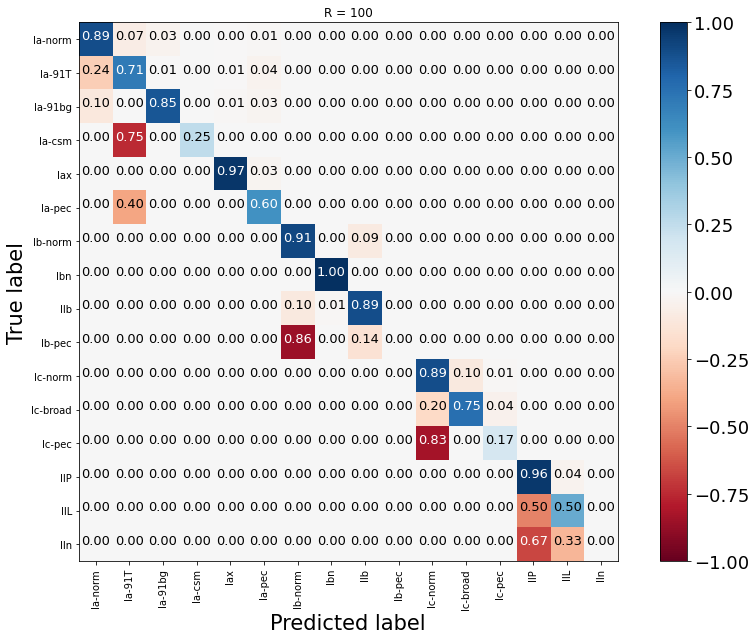

In [361]:
# classes = scsc.SN_Stypes_str[:-1]
# classes = np.insert(classes, 0, "Null")
CMtst = confusion_matrix(Ytst, Ptst)#, labels=classes)

plot_cm(CMtst, classes, R, normalize=True, savepath="./cm_tst.pdf")

In [364]:
f1_score(Ytst, Ptst, average="macro")

0.6372545547026665